# All Weather Strategy v1.0 - Baseline (Pure Risk Parity)

Implementation of Ray Dalio's All Weather Strategy for A-share market using pure risk parity optimization (as described in PDF).

**Performance (2018-2026)**:
- Annual Return: 3.71%
- Sharpe Ratio: 0.30
- Max Drawdown: -4.12%
- Strategy: Pure risk parity, weekly rebalancing, no constraints

## 1. Setup & Imports

In [ ]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.optimizer import optimize_weights, risk_contribution, validate_weights, check_risk_parity
from src.portfolio import Portfolio
from src.backtest import Backtester
from src.metrics import calculate_all_metrics
from src.data_loader import load_prices

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

# Display options
pd.options.display.float_format = '{:.4f}'.format

print("✓ Imports successful")

## 2. Load Data

In [ ]:
# Load ETF price data using data_loader
prices = load_prices('../data/etf_prices.csv')

print(f"Data shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")
print(f"ETFs: {list(prices.columns)}")
print(f"\nMissing values: {prices.isnull().sum().sum()}")

# Display first few rows
prices.head()

## 3. Calculate Current Risk Parity Weights

In [8]:
# Calculate weights using latest 100 days
recent_returns = prices.tail(100).pct_change().dropna()
weights = optimize_weights(recent_returns)

# Validate
is_valid, msg = validate_weights(weights)
print(f"Weight validation: {msg}")

# Check risk parity
cov_matrix = recent_returns.cov()
is_rp, std_rc = check_risk_parity(weights, cov_matrix)
print(f"Risk parity achieved: {is_rp} (std={std_rc:.6f})")

# Display weights
weight_df = pd.DataFrame({
    'ETF': prices.columns,
    'Weight': weights
}).sort_values('Weight', ascending=False)

print("\nCurrent Risk Parity Weights:")
print(weight_df.to_string(index=False))
print(f"\nTotal: {weights.sum():.4f}")

Weight validation: Valid
Risk parity achieved: True (std=0.000000)

Current Risk Parity Weights:
      ETF  Weight
511260.SH  0.6190
511090.SH  0.1548
513500.SH  0.0546
510300.SH  0.0523
513300.SH  0.0418
518880.SH  0.0411
510500.SH  0.0363

Total: 1.0000


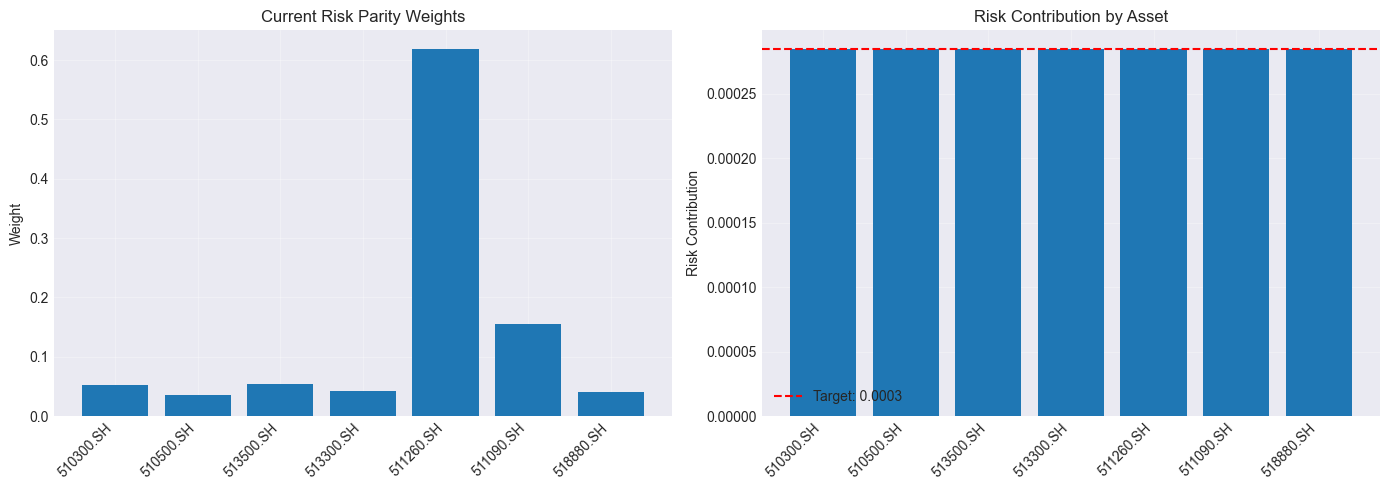

In [9]:
# Visualize current weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1.bar(range(len(weights)), weights)
ax1.set_xticks(range(len(weights)))
ax1.set_xticklabels(prices.columns, rotation=45, ha='right')
ax1.set_title('Current Risk Parity Weights')
ax1.set_ylabel('Weight')
ax1.grid(True, alpha=0.3)

# Risk contributions
risk_contribs = risk_contribution(weights, cov_matrix)
ax2.bar(range(len(risk_contribs)), risk_contribs)
ax2.axhline(risk_contribs.mean(), color='r', linestyle='--', 
            label=f'Target: {risk_contribs.mean():.4f}')
ax2.set_xticks(range(len(risk_contribs)))
ax2.set_xticklabels(prices.columns, rotation=45, ha='right')
ax2.set_title('Risk Contribution by Asset')
ax2.set_ylabel('Risk Contribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Run Backtest

In [10]:
# Initialize backtester
backtester = Backtester(
    prices=prices,
    initial_capital=1_000_000,
    rebalance_freq='W-MON',  # Weekly on Monday
    lookback=100,
    commission_rate=0.0003  # 0.03%
)

# Run from 2018-01-01
print("Running backtest from 2018-01-01...\n")
results = backtester.run(start_date='2018-01-01')

print("\n" + "="*60)
print("Backtest Complete!")
print("="*60)
print(f"Final Value: ¥{results['final_value']:,.0f}")
print(f"Total Return: {results['total_return']:.2%}")
print(f"Rebalances: {results['rebalance_count']}")
print(f"Trades: {results['trade_count']}")
print(f"Total Commissions: ¥{results['total_commissions']:,.0f}")
print(f"Turnover: {results['turnover']:.2f}x")

Running backtest from 2018-01-01...

Backtest period: 2018-01-01 to 2026-01-28
Rebalance dates: 422
[2018-01-08] Rebalanced: 2 trades, Value: ¥1,000,000
[2018-01-15] Rebalanced: 1 trades, Value: ¥999,701
[2018-01-22] Rebalanced: 0 trades, Value: ¥999,701
[2018-01-29] Rebalanced: 0 trades, Value: ¥999,701
[2018-02-05] Rebalanced: 0 trades, Value: ¥999,701
[2018-02-12] Rebalanced: 0 trades, Value: ¥999,701
[2018-02-26] Rebalanced: 0 trades, Value: ¥999,701
[2018-03-05] Rebalanced: 0 trades, Value: ¥999,701
[2018-03-12] Rebalanced: 0 trades, Value: ¥999,701
[2018-03-19] Rebalanced: 0 trades, Value: ¥999,701
[2018-03-26] Rebalanced: 0 trades, Value: ¥999,701
[2018-04-02] Rebalanced: 0 trades, Value: ¥999,701
[2018-04-09] Rebalanced: 0 trades, Value: ¥999,701
[2018-04-16] Rebalanced: 0 trades, Value: ¥999,701
[2018-04-23] Rebalanced: 0 trades, Value: ¥999,701
[2018-05-07] Rebalanced: 0 trades, Value: ¥999,701
[2018-05-14] Rebalanced: 0 trades, Value: ¥999,701
[2018-05-21] Rebalanced: 0 trad

## 5. Plot Equity Curve

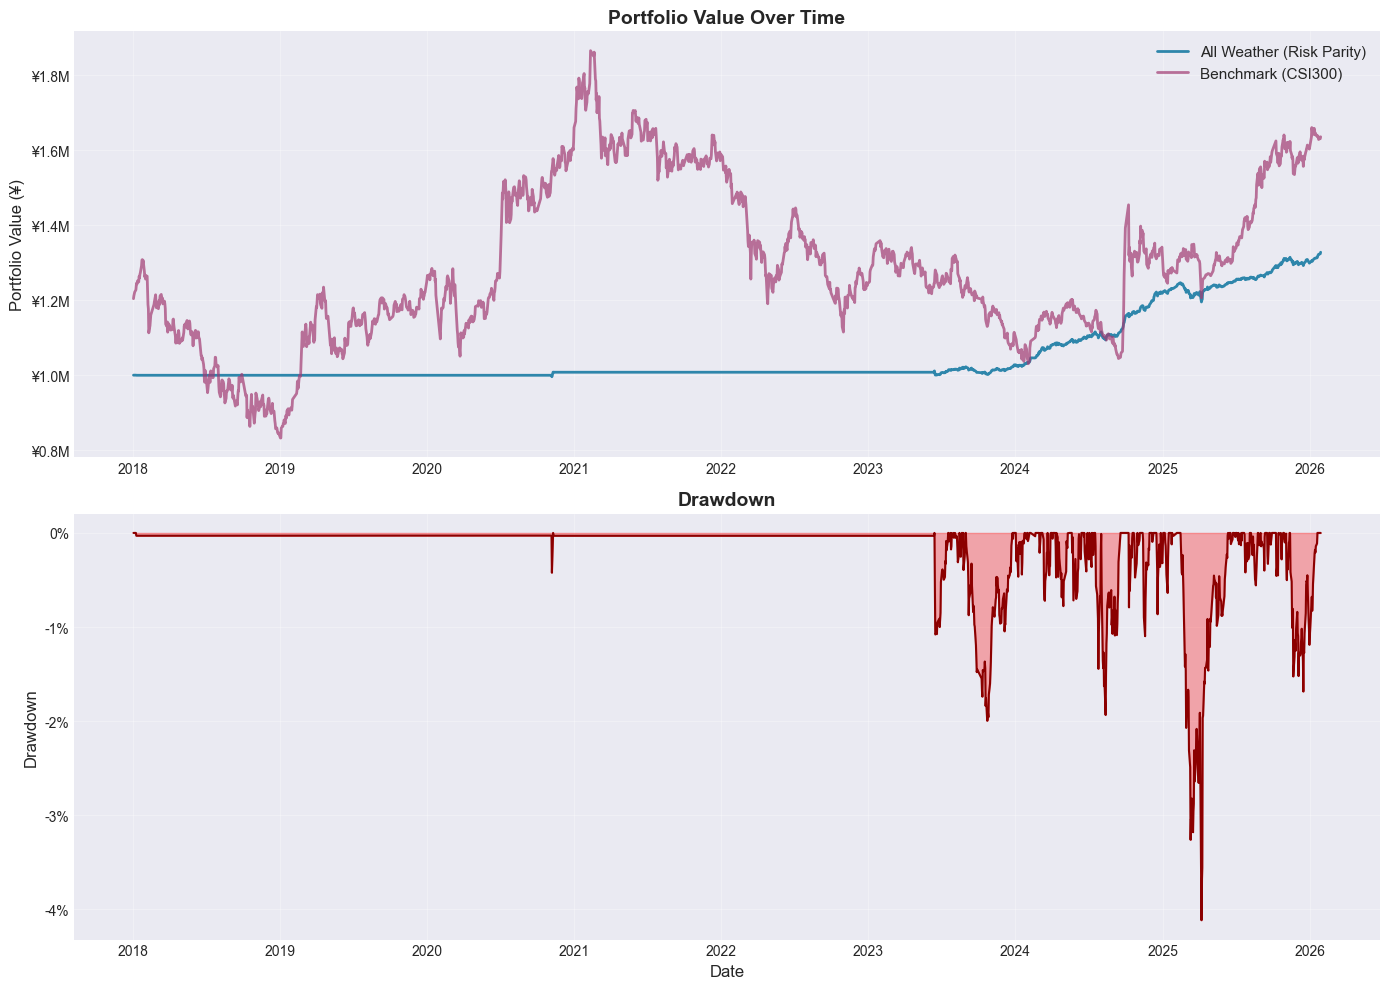

Max Drawdown: -4.12%


In [11]:
equity = results['equity_curve']
benchmark = (prices['510300.SH'] / prices['510300.SH'].iloc[0]) * 1_000_000
benchmark = benchmark.loc[equity.index]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Equity curve
ax1.plot(equity.index, equity, label='All Weather (Risk Parity)', linewidth=2, color='#2E86AB')
ax1.plot(benchmark.index, benchmark, label='Benchmark (CSI300)', 
         linewidth=2, alpha=0.7, color='#A23B72')
ax1.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value (¥)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'¥{x/1e6:.1f}M'))

# Drawdown
running_max = equity.expanding().max()
drawdown = (equity - running_max) / running_max
ax2.fill_between(drawdown.index, drawdown, 0, alpha=0.3, color='red')
ax2.plot(drawdown.index, drawdown, color='darkred', linewidth=1.5)
ax2.set_title('Drawdown', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

plt.tight_layout()
plt.show()

print(f"Max Drawdown: {drawdown.min():.2%}")

## 6. Performance Metrics

In [12]:
# Calculate metrics
portfolio_returns = results['returns']
benchmark_returns = benchmark.pct_change().dropna()

portfolio_metrics = calculate_all_metrics(portfolio_returns, equity)
benchmark_metrics = calculate_all_metrics(benchmark_returns, benchmark)

# Create comparison table
comparison = pd.DataFrame({
    'All Weather': [
        f"{portfolio_metrics['annual_return']:.2%}",
        f"{portfolio_metrics['annual_volatility']:.2%}",
        f"{portfolio_metrics['sharpe_ratio']:.2f}",
        f"{portfolio_metrics['sortino_ratio']:.2f}",
        f"{portfolio_metrics['max_drawdown']:.2%}",
        f"{portfolio_metrics['calmar_ratio']:.2f}",
        f"{portfolio_metrics['win_rate']:.2%}"
    ],
    'Benchmark': [
        f"{benchmark_metrics['annual_return']:.2%}",
        f"{benchmark_metrics['annual_volatility']:.2%}",
        f"{benchmark_metrics['sharpe_ratio']:.2f}",
        f"{benchmark_metrics['sortino_ratio']:.2f}",
        f"{benchmark_metrics['max_drawdown']:.2%}",
        f"{benchmark_metrics['calmar_ratio']:.2f}",
        f"{benchmark_metrics['win_rate']:.2%}"
    ],
    'PDF Target': [
        '20-25%',
        '~5%',
        '3.0-4.0',
        '-',
        '6-10%',
        '-',
        '-'
    ]
}, index=[
    'Annual Return',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio',
    'Max Drawdown',
    'Calmar Ratio',
    'Win Rate'
])

print("\n" + "="*80)
print("PERFORMANCE METRICS (2018-{})" . format(equity.index[-1].year))
print("="*80)
print(comparison)
print("="*80)


PERFORMANCE METRICS (2018-2026)
                  All Weather Benchmark PDF Target
Annual Return           3.71%     4.02%     20-25%
Annual Volatility       2.42%    21.98%        ~5%
Sharpe Ratio             0.30      0.05    3.0-4.0
Sortino Ratio            0.23      0.07          -
Max Drawdown           -4.12%   -44.75%      6-10%
Calmar Ratio             0.90      0.09          -
Win Rate               27.26%    49.62%          -


## 7. Weight Evolution Over Time

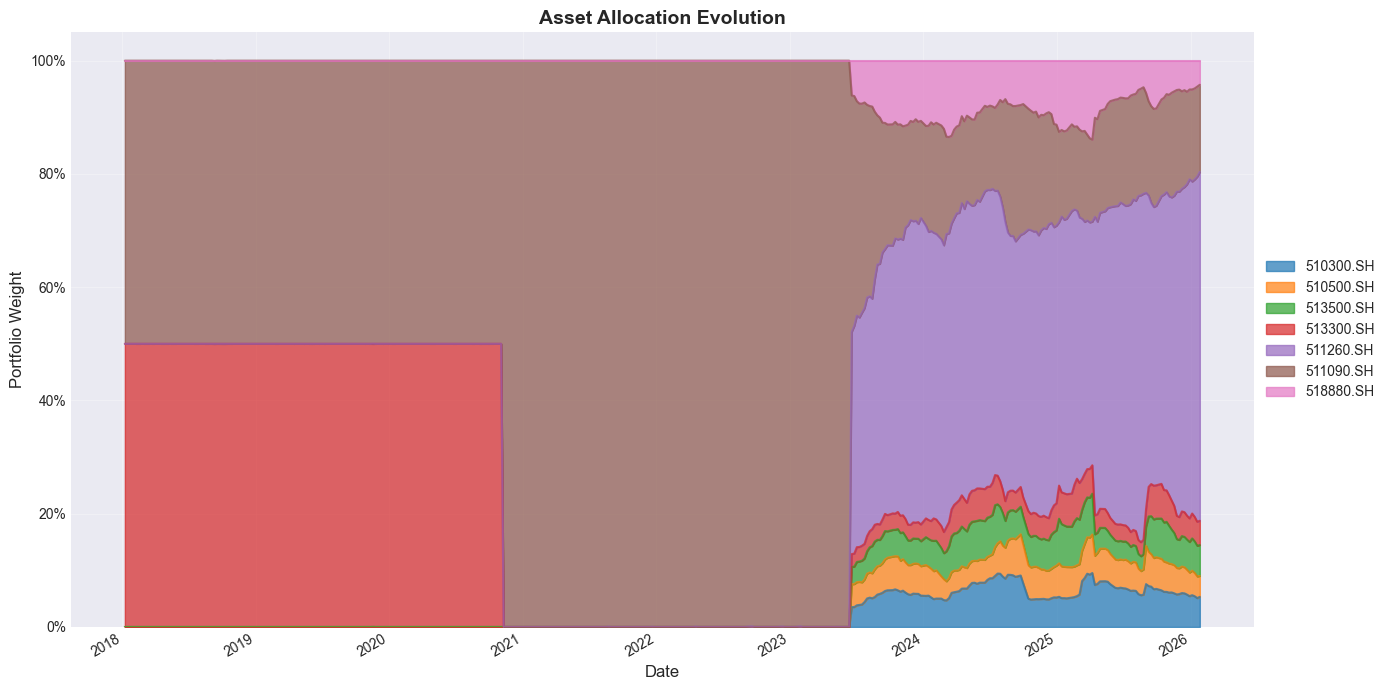


Latest Rebalance Weights:
511260.SH   0.6161
511090.SH   0.1538
513500.SH   0.0546
510300.SH   0.0532
513300.SH   0.0428
518880.SH   0.0426
510500.SH   0.0369
Name: 2026-01-26 00:00:00, dtype: float64


In [13]:
weights_df = results['weights_history']

if not weights_df.empty:
    # Stacked area chart
    fig, ax = plt.subplots(figsize=(14, 7))
    weights_df.plot.area(stacked=True, ax=ax, alpha=0.7)
    ax.set_title('Asset Allocation Evolution', fontsize=14, fontweight='bold')
    ax.set_ylabel('Portfolio Weight', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    plt.tight_layout()
    plt.show()
    
    # Show latest weights
    print("\nLatest Rebalance Weights:")
    print(weights_df.iloc[-1].sort_values(ascending=False))
else:
    print("No weight history available")

## 8. Risk Contribution Analysis

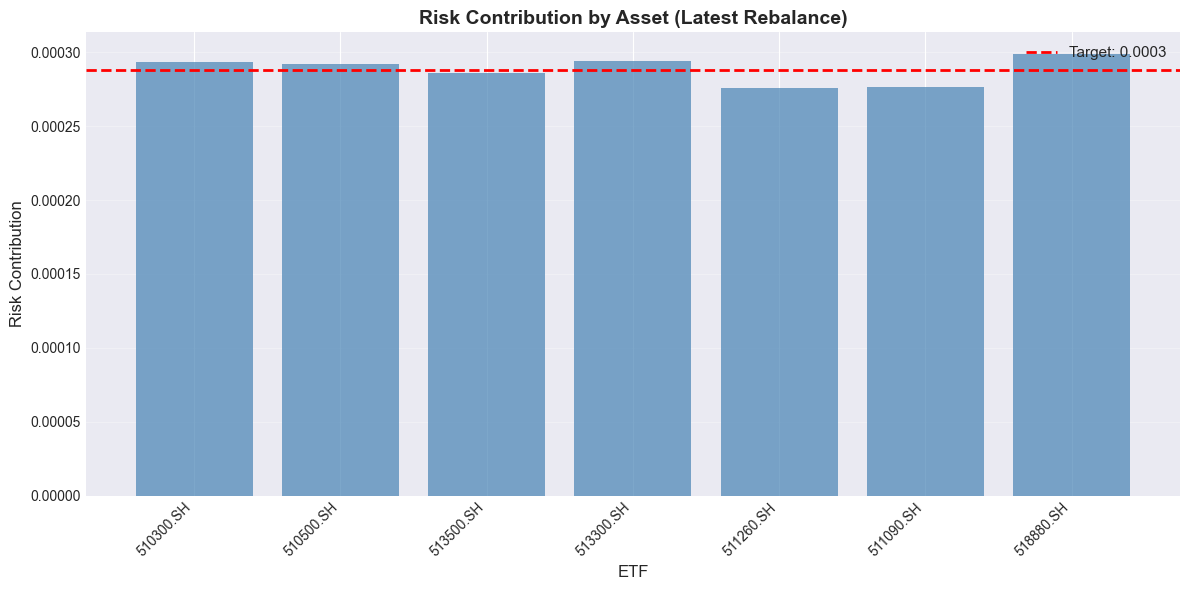


Risk Contributions (should be equal):
  510300.SH: 0.0003
  510500.SH: 0.0003
  513500.SH: 0.0003
  513300.SH: 0.0003
  511260.SH: 0.0003
  511090.SH: 0.0003
  518880.SH: 0.0003

Std dev of risk contributions: 0.000009
(Lower is better - perfect risk parity has std=0)


In [14]:
if not weights_df.empty:
    # Latest weights and risk contributions
    latest_weights = weights_df.iloc[-1].values
    latest_returns = prices.tail(100).pct_change().dropna()
    latest_cov = latest_returns.cov()
    latest_risk_contribs = risk_contribution(latest_weights, latest_cov)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = range(len(latest_risk_contribs))
    ax.bar(x, latest_risk_contribs, alpha=0.7, color='steelblue')
    ax.axhline(latest_risk_contribs.mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Target: {latest_risk_contribs.mean():.4f}')
    ax.set_xticks(x)
    ax.set_xticklabels(weights_df.columns, rotation=45, ha='right')
    ax.set_title('Risk Contribution by Asset (Latest Rebalance)', 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Risk Contribution', fontsize=12)
    ax.set_xlabel('ETF', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print("\nRisk Contributions (should be equal):")
    for etf, rc in zip(weights_df.columns, latest_risk_contribs):
        print(f"  {etf}: {rc:.4f}")
    print(f"\nStd dev of risk contributions: {latest_risk_contribs.std():.6f}")
    print("(Lower is better - perfect risk parity has std=0)")

## 9. Export Results

Save key results for documentation.

In [15]:
# Save results to dict for documentation
export_results = {
    'backtest_period': f"{equity.index[0].strftime('%Y-%m-%d')} to {equity.index[-1].strftime('%Y-%m-%d')}",
    'final_value': results['final_value'],
    'total_return': results['total_return'],
    'metrics': portfolio_metrics,
    'benchmark_metrics': benchmark_metrics,
    'rebalance_count': results['rebalance_count'],
    'trade_count': results['trade_count'],
    'total_commissions': results['total_commissions']
}

print("Results ready for export to v1.0_baseline.md")
print(f"\nBacktest period: {export_results['backtest_period']}")
print(f"Final value: ¥{export_results['final_value']:,.0f}")
print(f"Total return: {export_results['total_return']:.2%}")

Results ready for export to v1.0_baseline.md

Backtest period: 2018-01-02 to 2026-01-28
Final value: ¥1,327,744
Total return: 32.77%
